> ### Matrix_QM_serial.ipynb
> ### Serial Lanczos Algorithm for 1D Quantum Mechanics
> ### Author: Dhruv Patel (2130292), Mohammadreza Khansari (2132180)
> ### Date: 31st March 2025

In [ ]:
import numpy as np
from scipy.sparse.linalg import eigsh

# =============================================================================
# Lanczos Algorithm Implementation (Serial Version)
# =============================================================================

def Lanczos_algorithm(m, n, a):
    """
    Implements the serial Lanczos algorithm to approximate the eigenvalues
    of a Hamiltonian operator defined on a grid

    Args:
        m (int): Krylov subspace size (number of Lanczos iterations)
        n (int): Total number of spatial grid points
        a (float): Grid spacing

    Returns:
        eigenvalues (ndarray): The 10 smallest eigenvalues computed from the
                               tridiagonal Lanczos matrix
    """

    # Initializing Lanczos vectors and coefficients
    v = np.zeros((n, m))    # Orthonormal basis
    B = np.zeros(m - 1)     # Off-diagonal elements (beta coefficients)
    alpha = np.zeros(m)     # Diagonal elements (alpha coefficients)

    # Initializing and normalizing the starting vector
    v1 = np.random.randn(n)
    v1 /= np.linalg.norm(v1)

    # Precompute the spatial grid positions
    # Assuming symmetry around zero, we use an odd number of grid points
    M = (n - 1) // 2
    x = a * np.arange(-M, M + 1)

    # First Lanczos Iteration: Applying the Hamiltonian operator using Ĥv
    w1_p = Hv(v1, a, x)
    a1 = w1_p @ v1
    w1 = w1_p - a1 * v1
    alpha[0] = a1
    v[:, 0] = v1

    # Lanczos iteration loop
    for j in range(1, m):
        # Computing the beta coefficient
        B[j - 1] = np.linalg.norm(w1)

        # Handling the Lanczos breakdown (i.e., when the norm is nearly zero)
        if np.isclose(B[j-1], 0.0):
            # Restart if numerical breakdown occurs
            v[:, j] = np.random.randn(n)
            v[:, j] /= np.linalg.norm(v[:, j])
        else:
            # Normalizing the residual vector to obtain the next basis vector
            v[:, j] = w1 / B[j-1]
            v[:, j] /= np.linalg.norm(v[:, j])

        # Function call: Modified Gram-Schmidt reorthogonalization
        v = modified_gram_schmidt(v, j + 1)

        # Applying the Hamiltonian operator
        w1_p = Hv(v[:, j], a, x)
        alpha[j] = w1_p @ v[:, j]
        w1 = w1_p - alpha[j] * v[:, j] - B[j - 1] * v[:, j - 1]

    # Solving the tridiagonal system and evaluating the eigenvalues
    T = np.diag(alpha) + np.diag(B, -1) + np.diag(B, 1)
    eigenvalues, _ = eigsh(T, k=10, which='SM')
    return eigenvalues

# =============================================================================
# Hamiltonian Operator Function
# =============================================================================

def Hv(v, a, x):
    """
    Applies the Hamiltonian operator to a given vector

    The Hamiltonian includes both kinetic and potential energy contributions.
    The kinetic part uses a finite difference approximation (with periodic-like
    boundary handling using np.roll) and the potential part is modeled as a
    power-law potential

    Args:
        v (ndarray): Input vector (wavefunction) on the spatial grid
        a (float): Grid spacing
        x (ndarray): Array of spatial positions corresponding to the grid points

    Returns:
        result (ndarray): The result of applying the Hamiltonian to v
    """
    alpha_exp = 2   # Exponent in the potential term
    hbar = 1.0      # Reduced Planck's constant (set to 1 in natural units)

    # Kinetic energy (sparse momentum operator)
    kinetic = (hbar**2 / (2 * a**2)) * (2 * v - np.roll(v, 1) - np.roll(v, -1))

    # Potential energy (|x|^alpha_exp term)
    potential = 0.5 * np.abs(x)**alpha_exp * v

    return kinetic + potential

# =============================================================================
# Modified Gram-Schmidt Orthogonalization
# =============================================================================

def modified_gram_schmidt(matrix, k):
    """
    Performs Modified Gram-Schmidt orthogonalization to ensure numerical stability

    This function reorthogonalizes the current set of Lanczos vectors, ensuring
    that the basis remains orthonormal as new vectors are added

    Args:
        matrix (ndarray): Column vectors to orthogonalize
        k (int): Number of columns (vectors) to process

    Returns:
        ndarray: The matrix with orthonormalized columns
    """

    n, m = matrix.shape
    orthogonalized = matrix.copy()

    for i in range(k):
        # Normalizing the current vector
        norm_i = np.linalg.norm(orthogonalized[:, i])
        if norm_i > 0:
            orthogonalized[:, i] /= norm_i
        else:
            # If the vector norm is zero, generate a new random vector
            orthogonalized[:, i] = np.random.randn(n)
            orthogonalized[:, i] /= np.linalg.norm(orthogonalized[:, i])

        # Orthogonalizing the subsequent vectors
        for j in range(i + 1, k):
            proj = np.dot(orthogonalized[:, j], orthogonalized[:, i])
            orthogonalized[:, j] -= proj * orthogonalized[:, i]

    return orthogonalized

# =============================================================================
# Main Execution
# =============================================================================

if __name__ == "__main__":

    # Physical parameters
    L = 25.0    # System size [-L/2, L/2]
    N = 153     # Number of spatial grid points: 'odd' for symmetry
    m = N       # Krylov subspace size: controls Lanczos iterations (full orthogonalization)
    a = L / N   # Grid spacing

    # Executing the algorithm to evaluate eigenvalues
    eigenvalues = Lanczos_algorithm(m, N, a)

    # Saving the computed eigenvalues to a text file
    print(f"Computed eigenvalues: {eigenvalues}")
    np.savetxt('eigenvalues_serial.txt', eigenvalues,
              header=f"Eigenvalues computed with N = {N}, L = {L}, a = {a:.4f} (serial execution)")

    # Saving the computed Relative error to a text file
    # Expected eigenvalues: E_n = ħω(n + 1/2) for a harmonic oscillator
    # For our parameters ω = sqrt(k/m) = 1 (natural units)
    expected = [0.5 + i for i in range(10)]
    relative_error = (eigenvalues - expected) / expected
    print(f"\nRelative error: {relative_error}")
    np.savetxt('relative_error_serial.txt', relative_error,
              header="Relative error computed from eigenvalues and expected values (serial execution)")

Computed eigenvalues: [0.49916425 1.49581562 2.48910416 3.47901258 4.46552329 5.44861842
 6.42827974 7.40448874 8.37722654 9.34647393]

Relative error: [-0.00167149 -0.00278958 -0.00435834 -0.00599641 -0.00766149 -0.00934211
 -0.01103389 -0.01273483 -0.01444394 -0.01616064]


> ### Serial Implementation: Relative Error vs. Grid Resolution

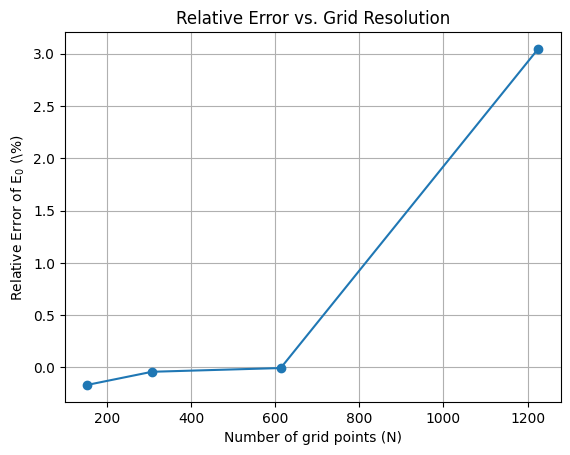

In [ ]:
import numpy as np
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

# =============================================================================
# Lanczos Algorithm Implementation (Serial Version)
# =============================================================================

def Lanczos_algorithm(m, n, a):
    """
    Implements the serial Lanczos algorithm to approximate the eigenvalues
    of a Hamiltonian operator defined on a grid

    Args:
        m (int): Krylov subspace size (number of Lanczos iterations)
        n (int): Total number of spatial grid points
        a (float): Grid spacing

    Returns:
        eigenvalues (ndarray): The 10 smallest eigenvalues computed from the
                               tridiagonal Lanczos matrix
    """

    # Initializing Lanczos vectors and coefficients
    v = np.zeros((n, m))    # Orthonormal basis
    B = np.zeros(m - 1)     # Off-diagonal elements (beta coefficients)
    alpha = np.zeros(m)     # Diagonal elements (alpha coefficients)

    # Initializing and normalizing the starting vector
    v1 = np.random.randn(n)
    v1 /= np.linalg.norm(v1)

    # Precompute the spatial grid positions
    # Assuming symmetry around zero, we use an odd number of grid points
    M = (n - 1) // 2
    x = a * np.arange(-M, M + 1)

    # First Lanczos Iteration: Applying the Hamiltonian operator using Ĥv
    w1_p = Hv(v1, a, x)
    a1 = w1_p @ v1
    w1 = w1_p - a1 * v1
    alpha[0] = a1
    v[:, 0] = v1

    # Lanczos iteration loop
    for j in range(1, m):
        # Computing the beta coefficient
        B[j - 1] = np.linalg.norm(w1)

        # Handling the Lanczos breakdown (i.e., when the norm is nearly zero)
        if np.isclose(B[j-1], 0.0):
            # Restart if numerical breakdown occurs
            v[:, j] = np.random.randn(n)
            v[:, j] /= np.linalg.norm(v[:, j])
        else:
            # Normalizing the residual vector to obtain the next basis vector
            v[:, j] = w1 / B[j-1]
            v[:, j] /= np.linalg.norm(v[:, j])

        # Function call: Modified Gram-Schmidt reorthogonalization
        v = modified_gram_schmidt(v, j + 1)

        # Applying the Hamiltonian operator
        w1_p = Hv(v[:, j], a, x)
        alpha[j] = w1_p @ v[:, j]
        w1 = w1_p - alpha[j] * v[:, j] - B[j - 1] * v[:, j - 1]

    # Solving the tridiagonal system and evaluating the eigenvalues
    T = np.diag(alpha) + np.diag(B, -1) + np.diag(B, 1)
    eigenvalues, _ = eigsh(T, k=10, which='SM')
    return eigenvalues

# =============================================================================
# Hamiltonian Operator Function
# =============================================================================

def Hv(v, a, x):
    """
    Applies the Hamiltonian operator to a given vector

    The Hamiltonian includes both kinetic and potential energy contributions.
    The kinetic part uses a finite difference approximation (with periodic-like
    boundary handling using np.roll) and the potential part is modeled as a
    power-law potential

    Args:
        v (ndarray): Input vector (wavefunction) on the spatial grid
        a (float): Grid spacing
        x (ndarray): Array of spatial positions corresponding to the grid points

    Returns:
        result (ndarray): The result of applying the Hamiltonian to v
    """
    alpha_exp = 2   # Exponent in the potential term
    hbar = 1.0      # Reduced Planck's constant (set to 1 in natural units)

    # Kinetic energy (sparse momentum operator)
    kinetic = (hbar**2 / (2 * a**2)) * (2 * v - np.roll(v, 1) - np.roll(v, -1))

    # Potential energy (|x|^alpha_exp term)
    potential = 0.5 * np.abs(x)**alpha_exp * v

    return kinetic + potential

# =============================================================================
# Modified Gram-Schmidt Orthogonalization
# =============================================================================

def modified_gram_schmidt(matrix, k):
    """
    Performs Modified Gram-Schmidt orthogonalization to ensure numerical stability

    This function reorthogonalizes the current set of Lanczos vectors, ensuring
    that the basis remains orthonormal as new vectors are added

    Args:
        matrix (ndarray): Column vectors to orthogonalize
        k (int): Number of columns (vectors) to process

    Returns:
        ndarray: The matrix with orthonormalized columns
    """

    n, m = matrix.shape
    orthogonalized = matrix.copy()

    for i in range(k):
        # Normalizing the current vector
        norm_i = np.linalg.norm(orthogonalized[:, i])
        if norm_i > 0:
            orthogonalized[:, i] /= norm_i
        else:
            # If the vector norm is zero, generate a new random vector
            orthogonalized[:, i] = np.random.randn(n)
            orthogonalized[:, i] /= np.linalg.norm(orthogonalized[:, i])

        # Orthogonalizing the subsequent vectors
        for j in range(i + 1, k):
            proj = np.dot(orthogonalized[:, j], orthogonalized[:, i])
            orthogonalized[:, j] -= proj * orthogonalized[:, i]

    return orthogonalized

# =============================================================================
# Main Execution
# =============================================================================

if __name__ == "__main__":

    # Baseline physical parameters
    L = 25.0                          # System size [-L/2, L/2]
    Ns = [153, 307, 613, 1225]        # Number of spatial grid points: 'odd' for symmetry
    m_fixed = 153                     # Krylov subspace size: Fixed for scaling analysis
    errors = []                       # errors: List initialization

    expected_lowest = 0.5             # Expected eigenvalue for n=0 (E0 = 0.5 in natural units)

    for N in Ns:
        a = L / N                     # Grid spacing
        m = m_fixed                   # Fixed m for scaling analysis

        # Executing the algorithm to evaluate eigenvalues
        eigenvalues = Lanczos_algorithm(m, N, a)
        relative_error = (eigenvalues[0] - expected_lowest) / expected_lowest
        errors.append(relative_error * 100)  # Store error in percent

    # Saving the grid resolutions and relative errors to a text file
    Ns_array = np.array(Ns)
    errors_array = np.array(errors)
    np.savetxt('grid_errors.txt', np.column_stack((Ns_array, errors_array)),
               header="N \t Relative_Error(%)", fmt='%d \t %.4f')

    # Plotting the results
    plt.figure()
    plt.plot(Ns, errors, marker='o', linestyle='-')
    plt.xlabel('Number of grid points (N)')
    plt.ylabel('Relative Error of E$_0$ (\%)')
    plt.title('Relative Error vs. Grid Resolution')
    plt.grid(True)
    plt.savefig('relative_error_plot.png')
    plt.show()